#### 核心知识：Q-learning算法和SARSA算法

Q-learning:

$Q(s_t,a_t)=Q(s_t,a_t)+\alpha [r_t+\gamma \max_a Q(s_{t+1},a)-Q(s_t,a_t)]$

SARSA:

$Q(s_t, a_t)=Q(s_t,a_t)+\alpha[r_t+\gamma Q(s_{t+1},a_{t+1})-Q(s_t,a_t)]$

In [1]:
# 引入对应的包
import gymnasium as gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from tqdm import trange

强化学习训练中具备很多超参数，这里采用Config类进行管理，其中：
* obs_size：状态空间
* act_size：动作空间
* max_timestep：单轮最大迭代次数
* num_episode：训练回合数
* plot_every：画图的滑窗
* alpha：学习率
* gamma：折扣因子
* epsilon：探索与利用的超参（后面会接触到）

In [2]:
class Configs:
    def __init__(self, 
                 env, 
                 max_timestep=300, 
                 num_episode=10000,
                 plot_every=100,
                 alpha=0.4,
                 gamma=0.99,
                 epsilon=0.1,
                 ):
        self.obs_size = env.observation_space.n
        self.act_size = env.action_space.n

        self.max_timestep = max_timestep
        self.num_episode = num_episode
        self.plot_every = plot_every

        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

此处定义$\epsilon$-greedy的探索方法：
* 生成一个0～1之间的随机数
* 如果该随机数小于$\epsilon$则随机在动作空间中选择一个行为
* 如果随机数大于$\epsilon$则选择当前策略下的最优行为

In [3]:
def epsilon_greedy(q, timestep, epsilon=None, test=False):
    if test == True:
        prob = np.zeros_like(q)
        prob[np.argmax(q)] = 1
        return prob
    epsilon = 1.0 / max(timestep, 1.0) if epsilon is None else epsilon

    prob = np.ones_like(q) * epsilon / q.shape[0]
    prob[np.argmax(q)] = (1 - epsilon) + epsilon / q.shape[0]
    return prob

此处定义Q值更新的函数，请根据TD更新公式完成td_target和q值的更新

In [4]:
def update_q_value(q, q_next, reward, alpha, gamma):
    """
    TODO: 
    请填写td_target和对应的q值更新
    """
    
    return 

首先实现SARSA算法

In [5]:
def sarsa(env, config):
    # 初始化Q值表格
    q_values = np.zeros([config.obs_size, config.act_size], dtype=np.float32)

    # 初始化表现滑窗
    scores = deque(maxlen=config.plot_every)
    avg_scores = deque(maxlen=config.num_episode)

    # 迭代最大回合
    for episode in trange(1, config.num_episode + 1):
        reward_sum = 0
        state, _ = env.reset()
        action_set = np.arange(config.act_size)
        
        # 利用epsilon_greedy方法计算行为选择概率
        prob = epsilon_greedy(q_values[state], 1, config.epsilon)
        # 根据概率进行行为选择
        action = np.random.choice(action_set, p=prob)
        
        # 迭代最大时间步
        for timestep in np.arange(config.max_timestep):

            env_feedbacks = env.step(action)
            next_state, reward, done = env_feedbacks[0], env_feedbacks[1], env_feedbacks[2]

            reward_sum += reward

            # 通过epsilon_greedy方法计算下一个状态的行为选择
            next_prob = epsilon_greedy(q_values[next_state], episode, config.epsilon)
            next_action = np.random.choice(action_set, p=next_prob)

            """
            TODO: 
            请填写next_q_value的值
            """
            next_q_value = None
            q_values[state, action] = update_q_value(q_values[state, action], 0 if done else next_q_value, reward, config.alpha, config.gamma)

            if done:
                break

            state, action = next_state, next_action

        scores.append(reward_sum)
                
        if episode % config.plot_every == 0:
            avg_scores.append(np.mean(scores))
    
    plt.plot(np.linspace(0, config.num_episode, len(avg_scores), endpoint=False), avg_scores, label="SARSA")
    plt.xlabel('Episode Number')
    plt.ylabel(f'Average Reward (Over Next {config.plot_every} Episodes)')

    print(f"Best Average Reward over {config.plot_every} Episodes: ", np.max(scores))
        
    return q_values


此时画出对应的迭代轮次-跑分曲线：

Discrete(4)
Discrete(48)


100%|██████████| 20000/20000 [01:05<00:00, 303.86it/s]


Best Average Reward over 100 Episodes:  -200


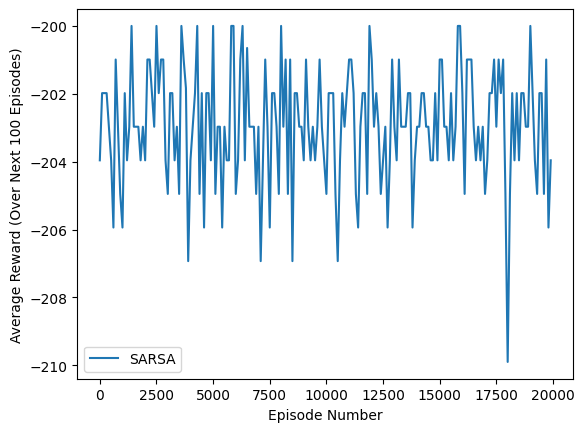

In [6]:
env = gym.make("CliffWalking-v1", render_mode="rgb_array")
print(env.action_space)
print(env.observation_space)

config = Configs(env, max_timestep=200, num_episode=20000, plot_every=100)

q_tables = sarsa(env, config)

# plot the curves
plt.legend()
plt.show()

此时我们可以通过sarsa函数返回的q_table查看每一个状态-行为值

同时利用该q_table进行可视化测试：

In [7]:
env = gym.make("CliffWalking-v1", render_mode="human")
state, _ = env.reset()
action_set = np.arange(config.act_size)

# 利用epsilon_greedy方法计算行为选择概率
prob = epsilon_greedy(q_tables[state], 1, config.epsilon, test=True)
# 根据概率进行行为选择
action = np.random.choice(action_set, p=prob)

# 迭代最大时间步
for timestep in np.arange(config.max_timestep):

    env_feedbacks = env.step(action)
    next_state, reward, done = env_feedbacks[0], env_feedbacks[1], env_feedbacks[2]

    # 通过epsilon_greedy方法计算下一个状态的行为选择
    next_prob = epsilon_greedy(q_tables[next_state], 10000, config.epsilon, test=True)
    next_action = np.random.choice(action_set, p=next_prob)

    next_q_value = q_tables[next_state, next_action]
    q_tables[state, action] = update_q_value(q_tables[state, action], 0 if done else next_q_value, reward, config.alpha, config.gamma)

    if done:
        break

    state, action = next_state, next_action

##### 实验2练习

根据上面的sarsa算法实现，完成q_learning算法实现。

In [8]:
def q_learning(env, config):
    q_values = np.zeros([config.obs_size, config.act_size], dtype=np.float32)

    return q_values


Discrete(4)
Discrete(48)


/tmp/ipykernel_5324/7462419.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


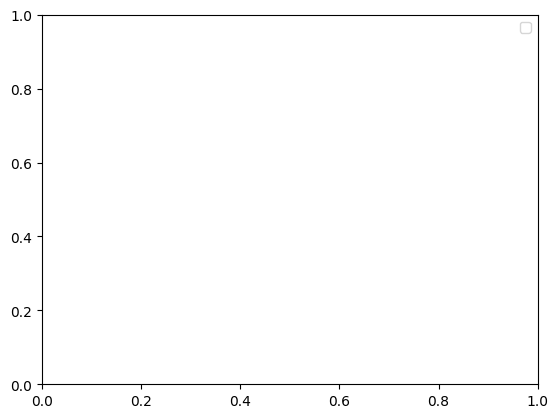

In [10]:
# 测试
env = gym.make("CliffWalking-v1", render_mode="rgb_array")
print(env.action_space)
print(env.observation_space)

config = Configs(env, max_timestep=200, num_episode=20000, plot_every=100)

q_tables = q_learning(env, config)

# plot the curves
plt.legend()
plt.show()  

In [12]:
env = gym.make("CliffWalking-v1", render_mode="human")
state, _ = env.reset()
action_set = np.arange(config.act_size)

# 利用epsilon_greedy方法计算行为选择概率
prob = epsilon_greedy(q_tables[state], 1, config.epsilon, test=True)
# 根据概率进行行为选择
action = np.random.choice(action_set, p=prob)

# 迭代最大时间步
for timestep in np.arange(config.max_timestep):

    env_feedbacks = env.step(action)
    next_state, reward, done = env_feedbacks[0], env_feedbacks[1], env_feedbacks[2]

    # 通过epsilon_greedy方法计算下一个状态的行为选择
    next_prob = epsilon_greedy(q_tables[next_state], 10000, config.epsilon, test=True)
    next_action = np.random.choice(action_set, p=next_prob)

    next_q_value = q_tables[next_state, next_action]
    q_tables[state, action] = update_q_value(q_tables[state, action], 0 if done else next_q_value, reward, config.alpha, config.gamma)

    if done:
        break

    state, action = next_state, next_action

对比human设定下的sarsa算法与q_learning算法动画，可以得出什么结论？